#### This is a project about text analytics of reviews for hotels in Austin area from tripadvisor.com

#### One challenge we encountered is, we are trying to deal with a context where people typically have mixed feelings. 

#### Here is a real review scraped from TripAdvisor:
####  

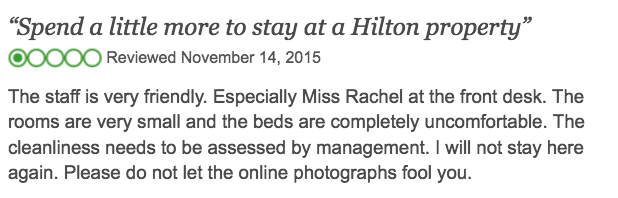

In [1]:
from IPython.display import Image
Image(filename='/Users/leeanthea/Desktop/tripAdvisorReview.png')

#### Above is a 1-star review, so this user probably have some negative experience staying in the hotel. But he did say very nice things about the staff and the receptionist, which are classified to the attribute "Service" in our system.

#### This python script is to construct an attribute-specific sentiment analysis system. The purpose is to seperate a visitor's impression on a particular attribute(i.e. Service, Amenity, Cleaniness, Location, etc) from his/her overall experience so that hotel managers are able to more clearly define which attribute to improve on and invest in.

####  

In [2]:
# Pretrained tokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import reuters
pst = PunktSentenceTokenizer()
pst.train(reuters.raw())

# Sentiment Analysis - Candidate Solution 1
from nltk import sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk_senti = SentimentIntensityAnalyzer()

# Sentiment Analysis - Candidate Solution 2
from textblob import TextBlob

In [3]:
# Sentiment Analysis - Candidate Solution 3 (Most accurate but compute-intensive)

import shlex
import subprocess
import re
def RateSentiment(sentiString): 
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar /Users/leeanthea/Downloads/SentiStrength.jar stdin sentidata /Users/leeanthea/Downloads/SentStrength_Data/ "),
                         stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    #stdout_text, stderr_text = p.communicate(sentiString.replace('\s ','+'))
    stdout_text, stderr_text = p.communicate(sentiString.replace('\s ','+'))
    #remove the tab spacing between the positive and negative ratings. e.g. 1    -5 -> 1-5
    stdout_text = stdout_text.rstrip().replace("\t"," ")
    if '-' in stdout_text:
        a,b = re.split('-',stdout_text)
        return int(a)-int(b)
    else:
        try:
            return int(stdout_text[0])
        except:
            return 0

RateSentiment("I didn't LOVE YOU")

2

In [4]:
# Attribute-Specific Sentiment Analysis 

def attr_senti(x,attr):
    # Tokenize each review by sentences
    tokens = pst.tokenize(x.decode('utf-8'))
    score = 0
    count = 0
    #normalize = len(tokens)/6.22
    for i in tokens:
        # Identify all the sentences that contain or describe an attribute
        if any(w in i for w in replaceDict[attr]) or (attr in i):
            senti_tb = TextBlob(i).sentiment.polarity 
            senti_nltk = nltk_senti.polarity_scores(i.encode('utf-8'))['pos'] - nltk_senti.polarity_scores(i.encode('utf-8'))['neg']
            #senti = RateSentiment(i.encode('utf-8'))
            count = count+1
            score =score + (senti_tb + senti_nltk)/2
    score = 1.0*score/max(count,1)
    return score

# We initially want to normalize the score by len(tokens)/6.22 (6.22 is the average length of reviews in the corpus)

In [5]:
import pandas as pd
import nltk
df = pd.read_pickle('tathx.pkl')
df['comment'] = df['comment'].str.encode('utf-8').str.strip('\n').str.lower()
df['hotel'] = df['hotel'].str.replace('_'," ").str.strip("-")
df.head()

,hotel,rating,helpful,comment
0,Crossland Studios Austin West,1.0,0,very bad stay. very dirty unsafe place to stay...
1,Crossland Studios Austin West,1.0,3,don't waste your time or money on this place. ...
2,Crossland Studios Austin West,1.0,0,the first room was dirty and had cockroaches a...
3,Crossland Studios Austin West,4.0,0,had to be in austin decided to stay at this ho...
4,Crossland Studios Austin West,1.0,2,worst experience ever !!a room for 60 dollars ...


In [6]:
r = pd.read_excel('/Users/leeanthea/Downloads/tripAdvisor_unigram.xlsx')
replaceDict = {}
r['replace'] = r['replace'].str.strip()
r['search'] = r['search'].str.strip()
for a in r['replace'].unique():
    replaceDict[a.strip()] = r[r['replace']==a.strip()].search.unique().tolist()

replaceDict

{u'ambience': [u'quiet', u'noise', u'safe', u'unsafe'],
 u'amenity': [u'gym',
  u'pool',
  u'breakfast',
  u'carpet',
  u'resturant',
  u'food',
  u'bar',
  u'parking',
  u'drink',
  u'coffee',
  u'shuttle',
  u'well maintained'],
 u'clean': [u'dirty',
  u'smell',
  u'odor',
  u'cockroach',
  u'floor',
  u'toilet',
  u'stain'],
 u'location': [u'convenience',
  u'convenient',
  u'airport',
  u'downtown',
  u'walking distance',
  u'6th street',
  u'easy access',
  u'south congress'],
 u'room': [u'bed',
  u'space',
  u'spacious',
  u'comfortable',
  u'curtain',
  u'hairdryer',
  u'bathroom',
  u'kitchen',
  u'tv'],
 u'service': [u'check in', u'checkin', u'staff', u'friendly', u'front desk'],
 u'value': [u'price', u'cheap', u'expensive', u'economical', u'happy hour']}

In [7]:
for a in replaceDict.keys():
    df[a] = df['comment'].apply(lambda x: attr_senti(x,a))
    print a

amenity
room
service
value
location
clean
ambience


In [8]:
df.head()

,hotel,rating,helpful,comment,amenity,room,service,value,location,clean,ambience
0,Crossland Studios Austin West,1.0,0,very bad stay. very dirty unsafe place to stay...,-0.400000,-0.000933,0.000,0.0,0.0,-0.141056,-0.585
1,Crossland Studios Austin West,1.0,3,don't waste your time or money on this place. ...,-0.384500,0.010080,0.000,0.0,0.0,-0.030764,0.000
2,Crossland Studios Austin West,1.0,0,the first room was dirty and had cockroaches a...,0.000000,0.000792,-0.349,0.0,0.0,-0.115278,0.000
3,Crossland Studios Austin West,4.0,0,had to be in austin decided to stay at this ho...,0.000000,0.167944,-0.271,0.0,0.0,0.117333,0.000
4,Crossland Studios Austin West,1.0,2,worst experience ever !!a room for 60 dollars ...,-0.049417,-0.292708,0.000,0.0,0.0,-0.292708,0.000


In [9]:
df.ix[7,'comment']

'the staff is very friendly. especially miss rachel at the front desk. the rooms are very small and the beds are completely uncomfortable. the cleanliness needs to be assessed by management. i will not stay here again. please do not let the online photographs fool you.'

In [10]:
for i in replaceDict.keys():
    print i,attr_senti(df.ix[7,'comment'],i)

amenity 0.0
room -0.31825
service 0.178375
value 0.0
location 0.0
clean 0.0
ambience 0.0


In [11]:
dfa = df[['hotel','rating','amenity','room','service','value','location','clean','ambience']].groupby('hotel').agg(lambda x: x.mean())

print len(dfa)

dfa.head()

122


,rating,amenity,room,service,value,location,clean,ambience
hotel,,,,,,,,
AT T Executive Education and Conference Center,4.583333,0.144659,0.271662,0.239762,0.023027,0.126719,0.149285,0.044725
Aloft Austin at the Domain,3.816667,0.126686,0.188578,0.207818,0.059616,0.188420,0.157521,0.015931
Americas Best Value Inn,2.283333,0.007055,0.063041,0.055157,0.073619,0.024935,0.065471,0.012136
Archer Hotel Austin,4.783333,0.124195,0.244437,0.252143,0.016476,0.159528,0.107967,0.012508
Austin Marriott South,4.383333,0.213323,0.198298,0.281206,0.036346,0.091311,0.213116,0.012426


In [12]:
# Aggregate (hotel-level) regression

from pandas import Series, DataFrame
import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('rating~amenity+room+service+value+location+clean+ambience', data=dfa, return_type='dataframe')
model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     97.26
Date:                Fri, 24 Feb 2017   Prob (F-statistic):           4.60e-45
Time:                        23:18:12   Log-Likelihood:                -10.245
No. Observations:                 122   AIC:                             36.49
Df Residuals:                     114   BIC:                             58.92
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0616      0.092     22.445      0.0

In [13]:
# Review-level regression

y, X = dmatrices('rating~amenity+room+service+value+location+clean+ambience', data=df, return_type='dataframe')
model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     505.6
Date:                Fri, 24 Feb 2017   Prob (F-statistic):               0.00
Time:                        23:18:12   Log-Likelihood:                -10518.
No. Observations:                7223   AIC:                         2.105e+04
Df Residuals:                    7215   BIC:                         2.111e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.0665      0.019    158.340      0.0